# Purpose

This script is used to apply the 8 timseries cross-validation models to the the test data (for 2022). As a test of sensitivity, we will fill all of the pump data with zero values and see how the models perform. They should be pretty terrible (performance wise) and we should see higher predicted temperatures than the actual temperatures.

In [1]:
#high level modules
import os
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/x8/v7bmckc139v2dqcm04jgfjlr0000gn/T/ipykernel_76503/3126687933.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
# custom modules
this_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/modeling/SMR_temp_forecast/arNN/"

imp.load_source("universals", os.path.join(this_dir, "universal_functions.py"))
from universals import load_pickle_file, twotemp_labels_features_test, predict_2_values_test, return_test_error_metrics

imp.load_source("vis", os.path.join(this_dir, "vis_functions.py"))
from vis import ts_plot, create_scatter_plot_test

We need to read in the transformed test data, apply the models, and save the predictions.

In [3]:
# import test data
file_path = os.path.expanduser("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/")

test_fn = os.path.join(file_path, "t2022_standardized_v2024-11-25.csv")
with open(test_fn) as f:
    test = pd.read_csv(f, sep=',')

In [4]:
test.columns

Index(['date', 'mean_1m_temp_degC', 'mean_0_5m_temp_degC',
       'mean_1m_temp_degC_m1', 'mean_0_5m_temp_degC_m1', 'air_temp_0',
       'air_temp_3', 'air_temp_6', 'air_temp_9', 'air_temp_12',
       ...
       'NF_q_m6', 'NF_q_m7', 'chip_q', 'chip_q_m1', 'chip_q_m2', 'chip_q_m3',
       'chip_q_m4', 'chip_q_m5', 'chip_q_m6', 'chip_q_m7'],
      dtype='object', length=169)

And now, we'll zero out all of the pump data. In order to do that, we need to know what the standardized pump value of 0 is. We can get that from the standardization file.

In [5]:
transform = pd.read_csv(os.path.join("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/", "mean_std_train_val_t2022_v2024-11-25.csv"), sep=',')
transform = transform.rename(columns={"Unnamed: 0": "feature"}).set_index("feature")

pump_cols = [col for col in test.columns if 'pump' in col]

for col in pump_cols:
    test[col] = (0 - transform.loc[col, 'mean']) / transform.loc[col, 'std']

And we need to filter this for our target date - Jul 1 through Sept 11.

In [6]:
# arrange the data by date
test['date'] = pd.to_datetime(test['date'])
test = test.sort_values(by='date')
test = test.loc[test['date'].between('2022-07-01', '2022-09-11')]

Now we need to apply the models to the test data, but first we need to format the data for the models

In [7]:
test_features, test_labels = twotemp_labels_features_test(test)

Load the models

In [8]:
# load the models
model_dir = '/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/models/leaky_basic_5/'

models = [f for f in os.listdir(model_dir) if 'history' not in f]

model_1 = load_pickle_file(models[0], model_dir)
model_2 = load_pickle_file(models[1], model_dir)
model_3 = load_pickle_file(models[2], model_dir)
model_4 = load_pickle_file(models[3], model_dir)
model_5 = load_pickle_file(models[4], model_dir)
model_6 = load_pickle_file(models[5], model_dir)
model_7 = load_pickle_file(models[6], model_dir)
model_8 = load_pickle_file(models[7], model_dir)


Now we need to apply the models to the test data and get the predictions, for which we also need the standarization parameters to back calculate.

In [9]:
t_mean_1m = transform['mean'].get('mean_1m_temp_degC')
t_std_1m = transform['std'].get('mean_1m_temp_degC')

t_mean_05m = transform['mean'].get('mean_0_5m_temp_degC')
t_std_05m = transform['std'].get('mean_0_5m_temp_degC')

test["pred_1m_1"], test["pred_05m_1"] = predict_2_values_test(model_1, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_2"], test["pred_05m_2"] = predict_2_values_test(model_2, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_3"], test["pred_05m_3"] = predict_2_values_test(model_3, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_4"], test["pred_05m_4"] = predict_2_values_test(model_4, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_5"], test["pred_05m_5"] = predict_2_values_test(model_5, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_6"], test["pred_05m_6"] = predict_2_values_test(model_6, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_7"], test["pred_05m_7"] = predict_2_values_test(model_7, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_8"], test["pred_05m_8"] = predict_2_values_test(model_8, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)

2024-11-26 12:04:44.559560: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


And now, let's make the ensemble prediction to assess the model performance.

In [10]:
test["ts_cv_ensemble_pred_1m"] = np.mean(test[['pred_1m_1', 'pred_1m_2', 'pred_1m_3', 'pred_1m_4', 'pred_1m_5', 'pred_1m_6', 'pred_1m_7', 'pred_1m_8']], axis=1)
test["ts_cv_ensemble_pred_05m"] = np.mean(test[['pred_05m_1', 'pred_05m_2', 'pred_05m_3', 'pred_05m_4', 'pred_05m_5', 'pred_05m_6', 'pred_05m_7', 'pred_05m_8']], axis=1)

In order to compare these with the actual values, we need to load the actual values and calculate the performance metrics. To do this, we will back-calculate using the mean and standard deviation.

In [11]:
test['mean_1m_temp_degC'] = test['mean_1m_temp_degC'] * t_std_1m + t_mean_1m
test['mean_0_5m_temp_degC'] = test['mean_0_5m_temp_degC'] * t_std_05m + t_mean_05m

Let's look at the data from 1m first:

In [12]:
return_test_error_metrics(test["mean_1m_temp_degC"], test["ts_cv_ensemble_pred_1m"])

Test Datset Error Metrics:
Mean Squared Error: 557.8947731810186
Mean Absolute Error: 20.097718169991854
Root Mean Squared Error: 23.619796213791062
Mean Absolute Percentage Error: 0.07377253655635006


(557.8947731810186,
 20.097718169991854,
 23.619796213791062,
 0.07377253655635006)

And then the data from 0-5m:

In [13]:
return_test_error_metrics(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"])

Test Datset Error Metrics:
Mean Squared Error: 3.2856136948174735
Mean Absolute Error: 1.693665860234373
Root Mean Squared Error: 1.8126261872811706
Mean Absolute Percentage Error: 0.12350032489359498


(3.2856136948174735,
 1.693665860234373,
 1.8126261872811706,
 0.12350032489359498)

Let's look at this in context of the data:

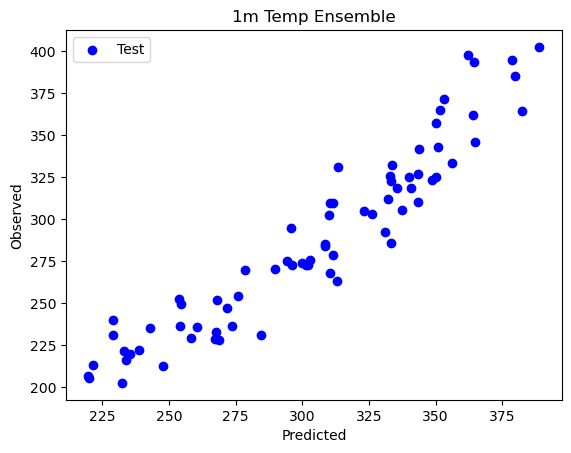

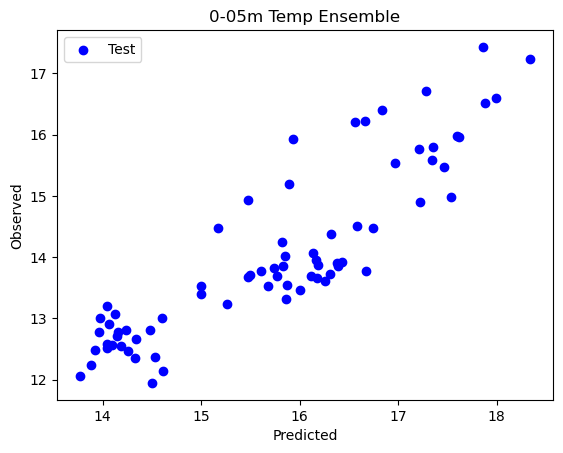

In [14]:
create_scatter_plot_test("1m Temp Ensemble", test["ts_cv_ensemble_pred_1m"], test["mean_1m_temp_degC"])
create_scatter_plot_test("0-05m Temp Ensemble", test["ts_cv_ensemble_pred_05m"], test["mean_0_5m_temp_degC"])

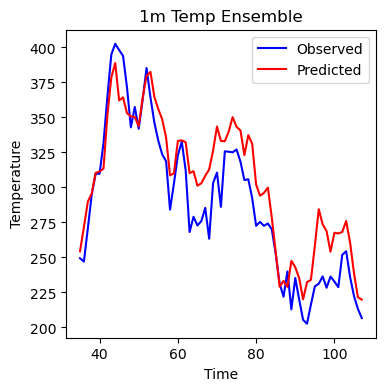

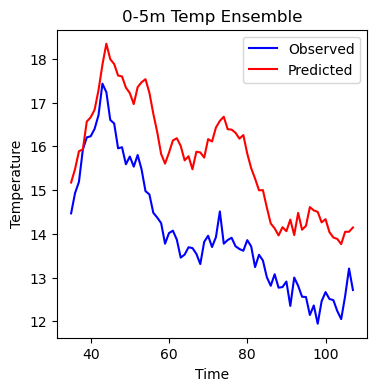

In [15]:
ts_plot(test["mean_1m_temp_degC"], test["ts_cv_ensemble_pred_1m"], "1m Temp Ensemble")
ts_plot(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"], "0-5m Temp Ensemble")


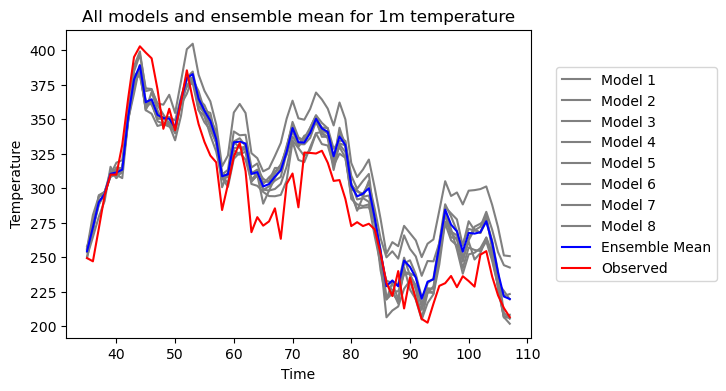

In [16]:
plt.figure(figsize=(6,4))
plt.plot(test["pred_1m_1"], label="Model 1", color='grey')
plt.plot(test["pred_1m_2"], label="Model 2", color='grey')
plt.plot(test["pred_1m_3"], label="Model 3", color='grey')
plt.plot(test["pred_1m_4"], label="Model 4", color='grey')
plt.plot(test["pred_1m_5"], label="Model 5", color='grey')
plt.plot(test["pred_1m_6"], label="Model 6", color='grey')
plt.plot(test["pred_1m_7"], label="Model 7", color='grey')
plt.plot(test["pred_1m_8"], label="Model 8", color='grey')
plt.plot(test["ts_cv_ensemble_pred_1m"], label="Ensemble Mean", color='blue')
plt.plot(test["mean_1m_temp_degC"], label="Observed", color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(bbox_to_anchor=(1.04, 0.9))
plt.title("All models and ensemble mean for 1m temperature")
plt.show()

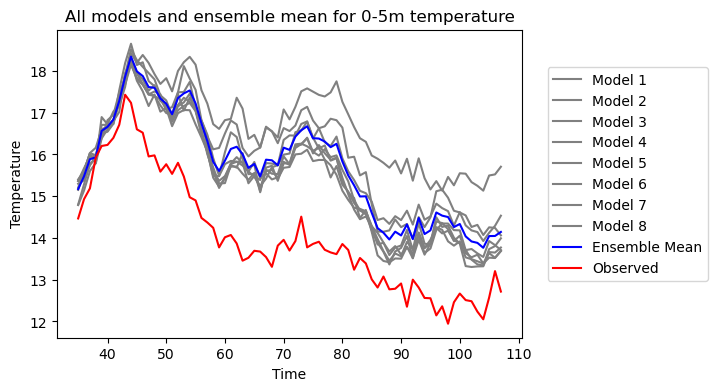

In [17]:
plt.figure(figsize=(6,4))
plt.plot(test["pred_05m_1"], label="Model 1", color='grey')
plt.plot(test["pred_05m_2"], label="Model 2", color='grey')
plt.plot(test["pred_05m_3"], label="Model 3", color='grey')
plt.plot(test["pred_05m_4"], label="Model 4", color='grey')
plt.plot(test["pred_05m_5"], label="Model 5", color='grey')
plt.plot(test["pred_05m_6"], label="Model 6", color='grey')
plt.plot(test["pred_05m_7"], label="Model 7", color='grey')
plt.plot(test["pred_05m_8"], label="Model 8", color='grey')
plt.plot(test["ts_cv_ensemble_pred_05m"], label="Ensemble Mean", color='blue')
plt.plot(test["mean_0_5m_temp_degC"], label="Observed", color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(bbox_to_anchor=(1.04, 0.9))
plt.title("All models and ensemble mean for 0-5m temperature")
plt.show()

## Calculate tempearture difference between no pump and observed

In [18]:
test['res_1m_1'] = test['pred_1m_1'] - test['mean_1m_temp_degC']
test['res_1m_2'] = test['pred_1m_2'] - test['mean_1m_temp_degC']
test['res_1m_3'] = test['pred_1m_3'] - test['mean_1m_temp_degC']
test['res_1m_4'] = test['pred_1m_4'] - test['mean_1m_temp_degC']
test['res_1m_5'] = test['pred_1m_5'] - test['mean_1m_temp_degC']
test['res_1m_6'] = test['pred_1m_6'] - test['mean_1m_temp_degC']
test['res_1m_7'] = test['pred_1m_7'] - test['mean_1m_temp_degC']
test['res_1m_8'] = test['pred_1m_8'] - test['mean_1m_temp_degC']
test['res_1m_ensemble'] = test['ts_cv_ensemble_pred_1m'] - test['mean_1m_temp_degC']

test['res_05m_1'] = test['pred_05m_1'] - test['mean_0_5m_temp_degC']
test['res_05m_2'] = test['pred_05m_2'] - test['mean_0_5m_temp_degC']
test['res_05m_3'] = test['pred_05m_3'] - test['mean_0_5m_temp_degC']
test['res_05m_4'] = test['pred_05m_4'] - test['mean_0_5m_temp_degC']
test['res_05m_5'] = test['pred_05m_5'] - test['mean_0_5m_temp_degC']
test['res_05m_6'] = test['pred_05m_6'] - test['mean_0_5m_temp_degC']
test['res_05m_7'] = test['pred_05m_7'] - test['mean_0_5m_temp_degC']
test['res_05m_8'] = test['pred_05m_8'] - test['mean_0_5m_temp_degC']
test['res_05m_ensemble'] = test['ts_cv_ensemble_pred_05m'] - test['mean_0_5m_temp_degC']

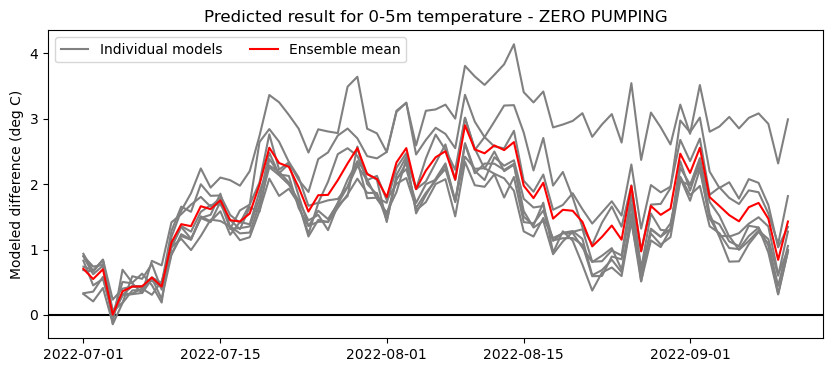

In [19]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_05m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_05m_2"], color='grey')
plt.plot(test['date'], test["res_05m_3"], color='grey')
plt.plot(test['date'], test["res_05m_4"], color='grey')
plt.plot(test['date'], test["res_05m_5"], color='grey')
plt.plot(test['date'], test["res_05m_6"], color='grey')
plt.plot(test['date'], test["res_05m_7"], color='grey')
plt.plot(test['date'], test["res_05m_8"], color='grey')
plt.plot(test['date'], test["res_05m_ensemble"], label="Ensemble mean", color='red')
plt.ylabel("Modeled difference (deg C)")
plt.legend(ncols = 3)
plt.title("Predicted result for 0-5m temperature - ZERO PUMPING")
plt.show()

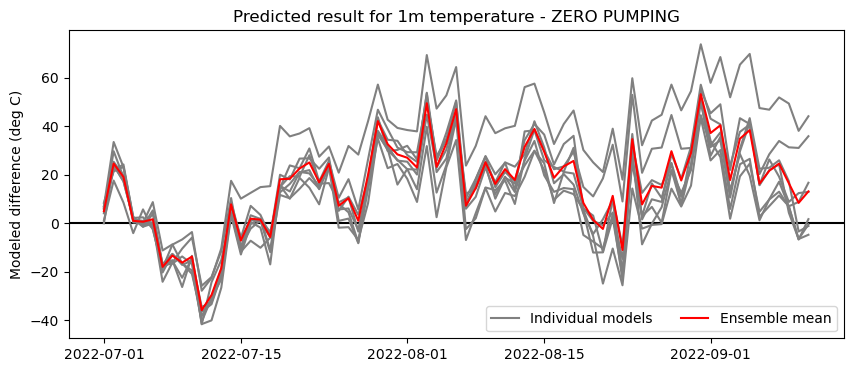

In [20]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_1m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_1m_2"], color='grey')
plt.plot(test['date'], test["res_1m_3"], color='grey')
plt.plot(test['date'], test["res_1m_4"], color='grey')
plt.plot(test['date'], test["res_1m_5"], color='grey')
plt.plot(test['date'], test["res_1m_6"], color='grey')
plt.plot(test['date'], test["res_1m_7"], color='grey')
plt.plot(test['date'], test["res_1m_8"], color='grey')
plt.plot(test['date'], test["res_1m_ensemble"], label="Ensemble mean", color='red')
plt.ylabel("Modeled difference (deg C)")
plt.legend(ncols = 3)
plt.title("Predicted result for 1m temperature - ZERO PUMPING")
plt.show()